## Prediction of novel materials for Li-ion battery

-- Predict the key properties of Li-based transition metal oxide, search for new candidates of Li-ion battery.

In [1]:
## import

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from __future__ import print_function
import re

from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import dask_searchcv as dcv
from dask.diagnostics import ProgressBar

import xgboost as xgb
from xgboost import XGBRegressor

plt.style.use('ggplot')
color_list = list(plt.rcParams['axes.prop_cycle'])
colors = [color_list[i]['color'] for i in range(len(color_list))]
pd.set_option("display.max_rows",200)

In [2]:
origin = pd.read_csv('final.csv')

origin = origin.rename(columns={"Materials Id": "Id",
                                "Formation Energy (eV)": "Ef",
                                "Spacegroup": "Sg",
                                "E Above Hull (eV)": "Eah",
                                "Band Gap (eV)": "Eg",
                                "Nsites": "Ns",
                                "Density (gm/cc)": "Density",
                                "Volume": "Vol",
                                "Crystal System": "Pg"}) # Point group
                                          
origin = origin.drop(["Count", "Has Bandstructure", "Unnamed: 12"], axis=1)
origin.sort_values(by='Formula').head()

,Id,Formula,Sg,Ef,Eah,Eg,Ns,Density,Vol,Pg
104,mp-762036,Li(CoO2)2,Pbcn,-1.528,0.033,0.000,28,4.515,277.738,orthorhombic
131,mvc-16808,Li(CoO2)2,P2/m,-1.499,0.061,0.304,7,4.655,67.347,monoclinic
130,mp-553952,Li(CoO2)2,P2/m,-1.499,0.061,0.411,7,4.688,66.877,monoclinic
83,mp-774082,Li(CoO2)2,P21,-1.560,0.000,0.628,56,4.783,524.343,monoclinic
128,mp-771481,Li(CoO2)2,P63mc,-1.502,0.059,0.000,28,4.961,252.800,hexagonal


In [5]:
## feature engineering - create, rescale, encode 

# Number of Li, TM, O
N_Li=[]
N_TM=[]
N_O=[]
for i, formule in enumerate(origin.Formula.values):
    try:
        N_Li.append(int(formule[2:4]))
    except ValueError:
        try:
            N_Li.append(int(formule[2]))
        except ValueError:
            N_Li.append(1)
    elems = re.sub(r"[0-9()]+", "", formule)
    N_TM.append((len(elems)-3)/2)

    after_O = formule[formule.index("O")+1:]
    try: 
        N_O.append(int(after_O))
    except ValueError:
        if ")" in formule:
            try:
                index_right = after_O.index(")")
                N_O.append(int(after_O[:index_right])*int(after_O[index_right+1:]))
            except ValueError:
                N_O.append(after_O[index_right+1:])
        else:
            N_O.append(int(1))

origin["N_Li"] = N_Li
origin["N_TM"] = N_TM
origin["N_O"] = N_O
origin["N_O"] = origin["N_O"].astype(np.int64)

origin["N_Li/Ns"] = origin["N_Li"]/origin["Ns"]
origin["N_TM/Ns"] = origin["N_TM"]/origin["Ns"]
origin["N_O/Ns"] = origin["N_O"]/origin["Ns"]

origin["N_Li/V"] = origin["N_Li"]/origin["Vol"]
origin["N_TM/V"] = origin["N_TM"]/origin["Vol"]
origin["N_O/V"] = origin["N_O"]/origin["Vol"]

origin["Ns/V"] = origin["Ns"]/origin["Vol"]
origin["Conductivity"] = origin["Eg"].where(origin["Eg"] == 0, 1)

le = LabelEncoder()
origin["Sg_code"] = le.fit_transform(origin.Sg)


data = pd.concat([origin, pd.get_dummies(origin[["Pg"]])], axis=1)
data.describe()

,Ef,Eah,Eg,Ns,Density,Vol,N_Li,N_TM,N_O,N_Li/Ns,...,Ns/V,Conductivity,Sg_code,Pg_cubic,Pg_hexagonal,Pg_monoclinic,Pg_orthorhombic,Pg_tetragonal,Pg_triclinic,Pg_trigonal
count,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,...,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000,2193.000000
mean,-2.074363,0.054316,0.668241,31.654811,3.958733,321.190518,4.667123,1.479252,11.505700,0.155756,...,0.100427,0.677155,32.720018,0.021432,0.022800,0.386685,0.125399,0.040128,0.297310,0.106247
std,0.474183,0.043648,0.809958,21.884898,0.612901,230.910887,5.663745,0.607626,9.950016,0.097111,...,0.009984,0.467671,25.731578,0.144852,0.149299,0.487102,0.331246,0.196303,0.457178,0.308224
min,-3.397000,0.000000,0.000000,3.000000,2.094000,30.260000,1.000000,0.000000,1.000000,0.007937,...,0.060068,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-2.361000,0.023000,0.000000,15.000000,3.643000,149.734000,2.000000,1.000000,6.000000,0.073529,...,0.093847,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-2.063000,0.051000,0.339000,24.000000,4.021000,233.740000,3.000000,1.000000,8.000000,0.142857,...,0.101041,1.000000,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,-1.773000,0.077000,1.124000,42.000000,4.355000,435.173000,5.000000,2.000000,12.000000,0.214286,...,0.107725,1.000000,38.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,-0.474000,0.899000,4.557000,140.000000,6.268000,1516.092000,47.000000,3.000000,58.000000,0.560000,...,0.123199,1.000000,84.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


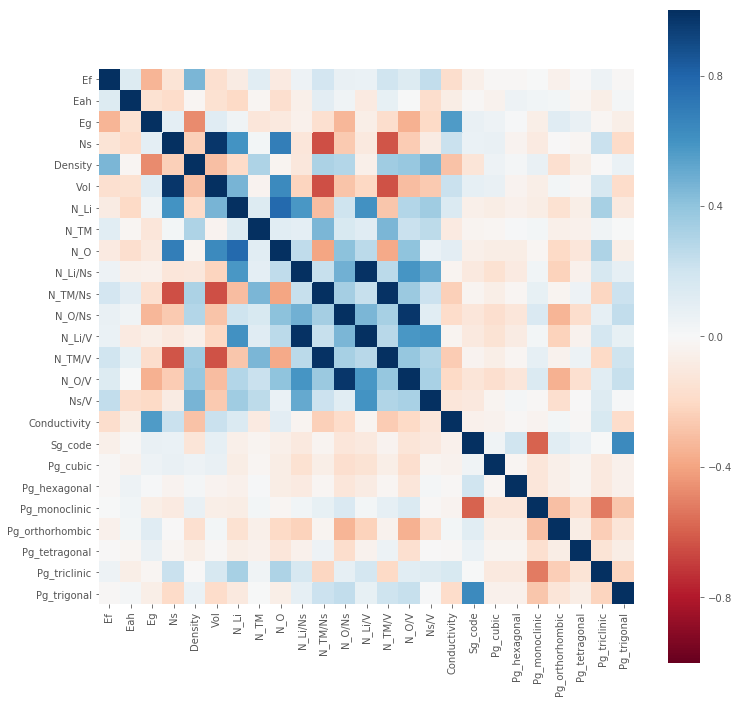

In [6]:
fig = plt.subplots(figsize=(12,12))
sns.heatmap(data.corr(), square=True, vmin=-1, vmax=1, cmap="RdBu")

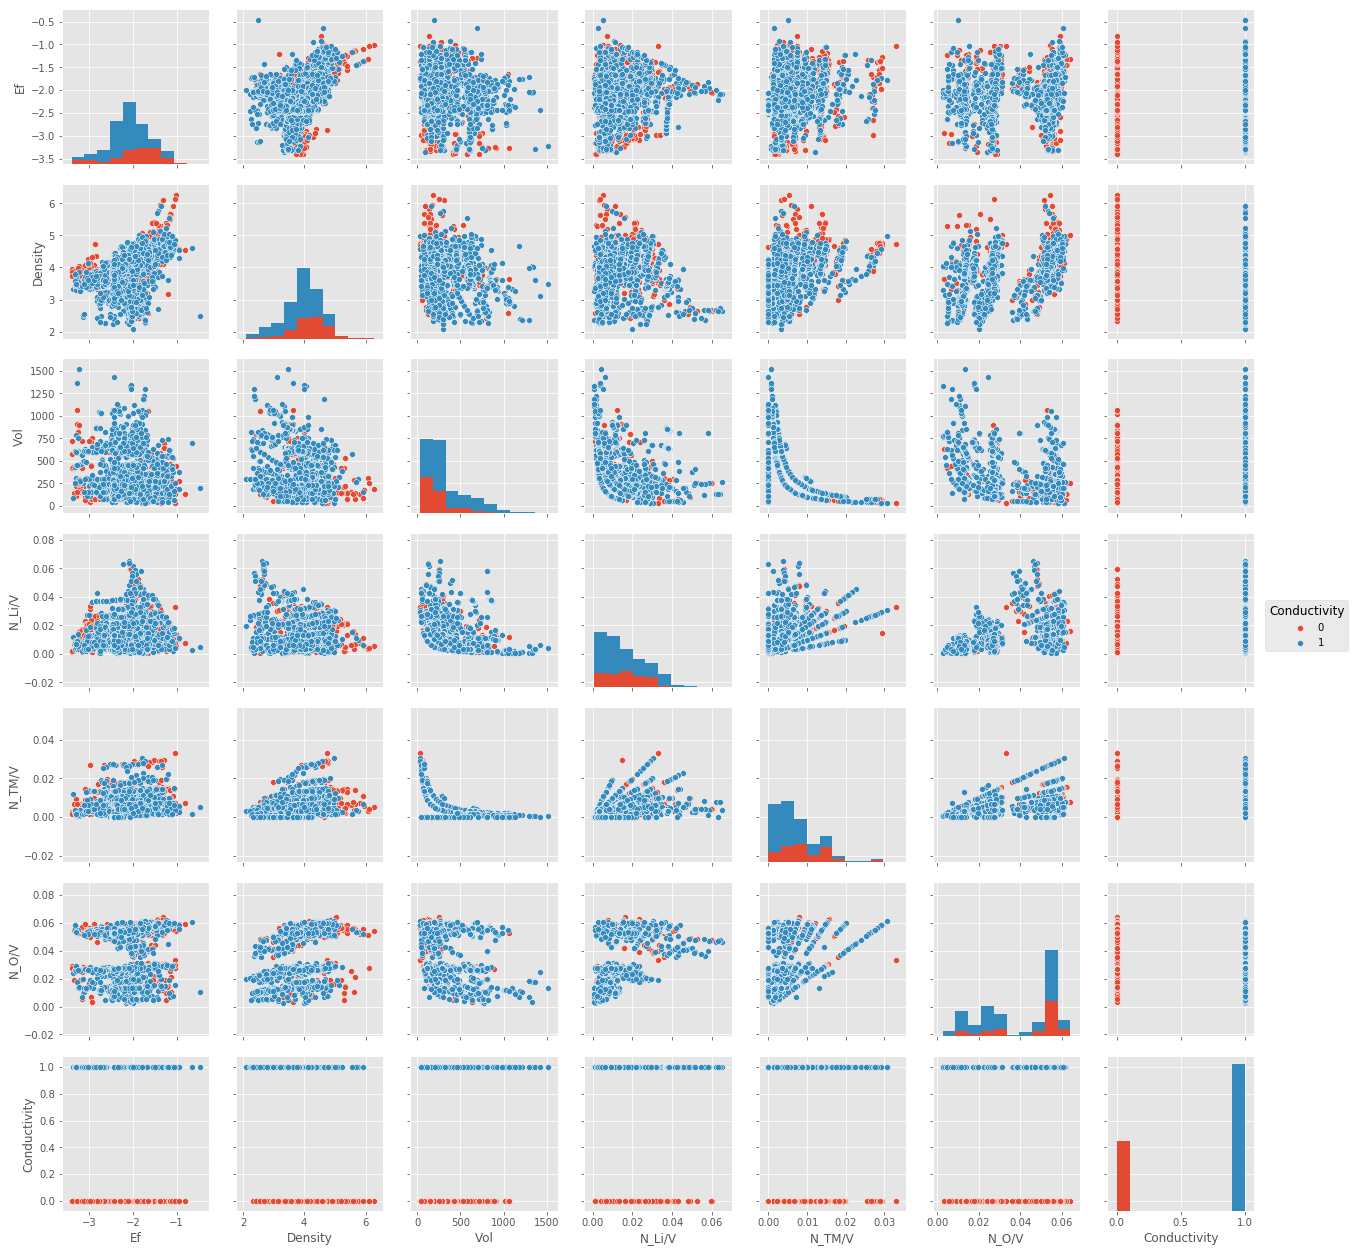

In [184]:
sns.pairplot(data[["Ef", "Density", "Vol", "N_Li/V", "N_TM/V", "N_O/V", "Conductivity"]], hue="Conductivity")

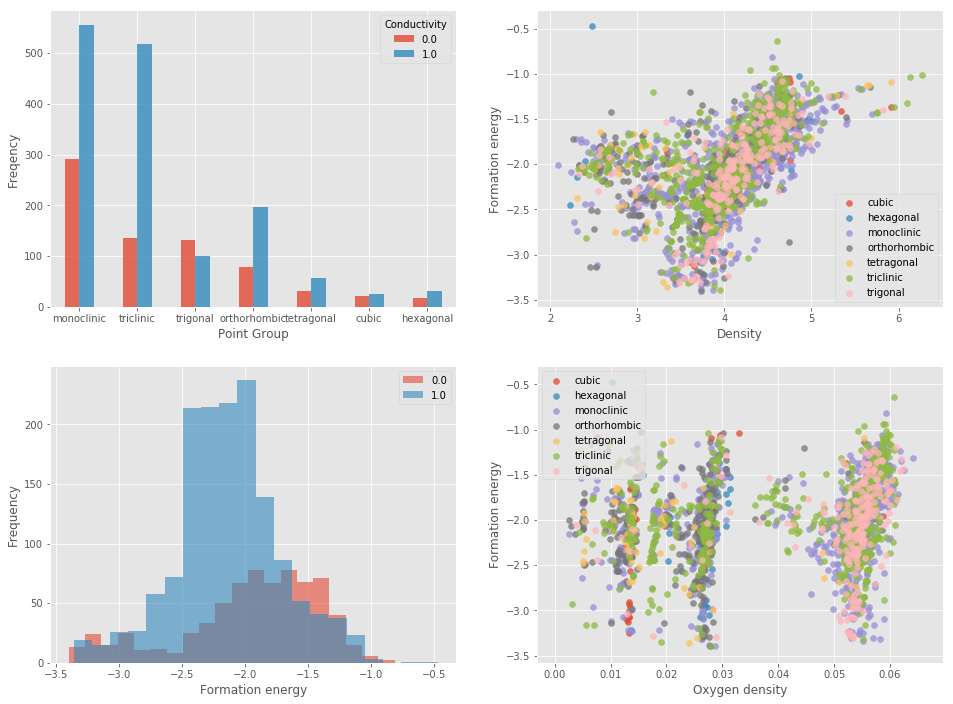

In [7]:
df_pg = data[["Pg", "N_O/V", "Density", "Conductivity", 'Ef']]

point_group_c = df_pg.groupby(["Pg"], sort=False)["Conductivity"].value_counts().unstack().sort_values(0, ascending=False)
point_group_f = df_pg.groupby(["Pg"])

fig, ax = plt.subplots(2,2, figsize=(16,12))

## fig.1
point_group_c.plot(kind="bar", ax=ax[0,0], rot=0, alpha=0.8)
ax[0,0].set(xlabel="Point Group", ylabel="Freqency")

## fig.2
keys = []
for i, (key, group) in enumerate(point_group_f):
    keys.append(key)
    ax[0,1].set_xlabel('Density')
    ax[0,1].set_ylabel('Formation energy')
    ax[0,1].scatter(group['Density'], group['Ef'], alpha=0.75, label=key)
    ax[0,1].legend()
    
## fig.3
df_pg.groupby(["Conductivity"])["Ef"].plot.hist(alpha=0.6, ax=ax[1,0], bins=20)
ax[1,0].set(xlabel="Formation energy")
ax[1,0].legend()

## fig.4
keys = []
for i, (key, group) in enumerate(point_group_f):
    keys.append(key)
    ax[1,1].set_xlabel('Oxygen density')
    ax[1,1].set_ylabel('Formation energy')
    ax[1,1].scatter(group['N_O/V'], group['Ef'], alpha=0.75, label=key)
    ax[1,1].legend()

plt.show()

### Modeling

In [13]:
def opt_model(X, y, model, params, cv_search):
    '''
    model: any ml models;
    params: parameters corresponding to the model;
    cv_search: cross validation searching method;
    '''
    if cv_search == "GridSearchCV":
        method = dcv.GridSearchCV(model,
                            param_grid=params, 
                            scoring="neg_mean_squared_error",
                            cv=4,
                            n_jobs=8,
                            return_train_score=False)
    
    elif cv_search == "RandomizedSearchCV":
        method = dcv.RandomizedSearchCV(model, 
                            param_distributions=params,
                            scoring="neg_mean_squared_error",
                            cv=4,
                            n_iter=25,
                            n_jobs=8,
                            return_train_score=False)
         
    opt = method.fit(X, y)
    return opt

### Start with linear regression with original features

In [14]:
origin_features = ["Eah", "Ns", "Density", "Vol", "Sg_code"]
X_train, X_test, y_train, y_test = train_test_split(
    data[origin_features], data["Ef"], test_size=0.1, random_state=99)

In [16]:
model = Pipeline([('poly', PolynomialFeatures()), 
                  ('ridge', linear_model.Ridge(tol=0.0001))])
param_grid = dict(poly__degree=[1, 2, 3], ridge__alpha=[0.01, 0.1, 1, 10, 100])
with ProgressBar():
    prr = opt_model(X_train, y_train, model, param_grid, "GridSearchCV")

[########################################] | 100% Completed |  0.5s


In [17]:
results = pd.DataFrame(prr.cv_results_).sort_values(["rank_test_score"])
display(results.head())
print("Best models:", prr.best_estimator_)
print("Training MSE: {:.6f}".format(abs(prr.best_score_)))
print("Test MSE: {:.6f}".format(mean_squared_error(prr.best_estimator_.predict(X_test), y_test)))

,mean_fit_time,mean_score_time,mean_test_score,param_poly__degree,param_ridge__alpha,params,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,std_fit_time,std_score_time,std_test_score
11,0.035816,0.002925,-0.125810,3,0.1,"{u'poly__degree': 3, u'ridge__alpha': 0.1}",1,-0.128023,-0.121131,-0.115086,-0.138994,0.003097,0.000829,0.008881
10,0.038472,0.007258,-0.133365,3,0.01,"{u'poly__degree': 3, u'ridge__alpha': 0.01}",2,-0.159919,-0.123502,-0.112348,-0.137638,0.003710,0.003520,0.017771
12,0.036605,0.002296,-0.133833,3,1,"{u'poly__degree': 3, u'ridge__alpha': 1}",3,-0.141234,-0.125616,-0.122184,-0.146285,0.001128,0.000906,0.010161
13,0.035357,0.003071,-0.136461,3,10,"{u'poly__degree': 3, u'ridge__alpha': 10}",4,-0.145074,-0.126067,-0.124768,-0.149919,0.003403,0.001087,0.011180
6,0.016144,0.001058,-0.136527,2,0.1,"{u'poly__degree': 2, u'ridge__alpha': 0.1}",5,-0.143107,-0.122102,-0.135054,-0.145831,0.004216,0.000339,0.009220


Best models: Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.0001))])
Training MSE: 0.125810
Test MSE: 0.152383


In [22]:
## xgboost

model = XGBRegressor()
param_grid = {
     'learning_rate': [0.005, 0.001],
     'n_estimators': [1000, 1500],
     'max_depth': [2, 4, 6],
     'colsample_bytree': [0.4, 0.6, 0.8],
     'subsample': [0.4, 0.6, 0.8]
 }


with ProgressBar():
    xgbr = opt_model(X_train, y_train, model, param_grid, "RandomizedSearchCV")

[########################################] | 100% Completed | 38.9s


In [23]:
display(pd.DataFrame(xgbr.cv_results_).sort_values("rank_test_score").head())

print("Best models:", xgbr.best_estimator_)
print("Training MSE: {:.6f}".format(abs(xgbr.best_score_)))
print("Test MSE: {:.6f}".format(mean_squared_error(xgbr.best_estimator_.predict(X_test), y_test)))


,mean_fit_time,mean_score_time,mean_test_score,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,std_fit_time,std_score_time,std_test_score
17,5.398122,0.328427,-0.087553,0.8,0.005,6,1500,0.8,"{u'n_estimators': 1500, u'subsample': 0.8, u'l...",1,-0.091161,-0.083793,-0.084320,-0.090932,0.066901,0.045665,0.003501
8,4.735004,0.286282,-0.088131,0.8,0.005,6,1500,0.4,"{u'n_estimators': 1500, u'subsample': 0.4, u'l...",2,-0.091520,-0.085894,-0.085150,-0.089953,0.019935,0.050833,0.002679
20,3.484756,0.154008,-0.091028,0.8,0.005,6,1000,0.8,"{u'n_estimators': 1000, u'subsample': 0.8, u'l...",3,-0.092509,-0.088032,-0.088528,-0.095038,0.062815,0.035341,0.002894
13,3.736489,0.292260,-0.093595,0.4,0.005,6,1500,0.6,"{u'n_estimators': 1500, u'subsample': 0.6, u'l...",4,-0.095397,-0.093034,-0.093689,-0.092255,0.043535,0.020694,0.001159
4,2.347269,0.152772,-0.098840,0.4,0.005,6,1000,0.6,"{u'n_estimators': 1000, u'subsample': 0.6, u'l...",5,-0.098848,-0.097988,-0.100092,-0.098434,0.028391,0.021338,0.000784


Best models: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.005,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
       n_estimators=1500, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)
Training MSE: 0.087553
Test MSE: 0.119246


### XGBoost regression by adding new features

In [29]:
selected_features = data.columns.drop(["Id", "Formula", "Sg", "Pg", "Ef", "Eg", "Conductivity"])
X_train, X_test, y_train, y_test = train_test_split(
    data[selected_features], data["Ef"], test_size=0.1, random_state=99)

with ProgressBar():
    xgbr = opt_model(X_train, y_train, model, param_grid, "RandomizedSearchCV")


[########################################] | 100% Completed |  1min 18.7s


In [30]:
display(pd.DataFrame(xgbr.cv_results_).sort_values("rank_test_score").head())

print("Best models:", xgbr.best_estimator_)
print("Training MSE: {:.6f}".format(abs(xgbr.best_score_)))
print("Test MSE: {:.6f}".format(mean_squared_error(xgbr.best_estimator_.predict(X_test), y_test)))


,mean_fit_time,mean_score_time,mean_test_score,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,rank_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,std_fit_time,std_score_time,std_test_score
11,13.214604,0.287744,-0.063607,0.8,0.005,6,1500,0.8,"{u'n_estimators': 1500, u'subsample': 0.8, u'l...",1,-0.062113,-0.061644,-0.066236,-0.064436,0.061284,0.009352,0.001849
12,10.652660,0.331760,-0.066767,0.6,0.005,6,1500,0.8,"{u'n_estimators': 1500, u'subsample': 0.8, u'l...",2,-0.066479,-0.063664,-0.069717,-0.067207,0.076801,0.020536,0.002156
5,8.839262,0.147320,-0.068128,0.8,0.005,6,1000,0.8,"{u'n_estimators': 1000, u'subsample': 0.8, u'l...",3,-0.065622,-0.065938,-0.070849,-0.070108,0.029660,0.011838,0.002366
22,8.664110,0.301937,-0.068224,0.6,0.005,6,1500,0.4,"{u'n_estimators': 1500, u'subsample': 0.4, u'l...",4,-0.067866,-0.066272,-0.070086,-0.068672,0.116099,0.033619,0.001378
18,7.252611,0.127974,-0.075520,0.6,0.005,4,1500,0.8,"{u'n_estimators': 1500, u'subsample': 0.8, u'l...",5,-0.075668,-0.073667,-0.077395,-0.075351,0.109055,0.009344,0.001323


Best models: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.005,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
       n_estimators=1500, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)
Training MSE: 0.063607
Test MSE: 0.087454


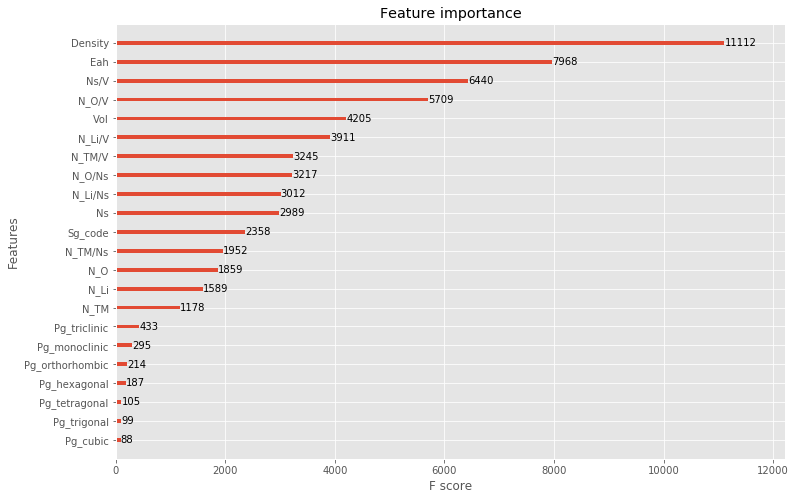

In [43]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
xgb.plot_importance(xgbr.best_estimator_, ax=ax)

In [58]:
X, y = data[selected_features], data["Ef"]
dtrain = xgb.DMatrix(X, label=y)

results = xgb.cv(xgbr.best_params_, dtrain, 1500, 
                 nfold=5, metrics='rmse', verbose_eval=400)

[0]	train-rmse:2.60488+0.000860178	test-rmse:2.60491+0.00343845
[400]	train-rmse:0.4378+0.00148524	test-rmse:0.462198+0.00418933
[800]	train-rmse:0.186424+0.00326361	test-rmse:0.266985+0.00724536
[1200]	train-rmse:0.142792+0.00262187	test-rmse:0.25065+0.00803388
[1499]	train-rmse:0.124001+0.00201567	test-rmse:0.24571+0.00832691


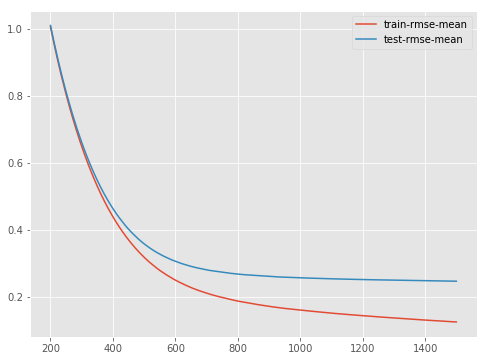

In [59]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
results[["train-rmse-mean", "test-rmse-mean"]][200:].plot(ax=ax)